In [1]:
#!wget https://raw.githubusercontent.com/irvingvasquez/practicas_pytorch/master/helper.py -O helperr.py

In [1]:
# importamos paquetes
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import pandas as pd
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import helperr as helper

In [4]:
import os
from torch.utils.data import Dataset, DataLoader

"""
	Excel file with the data
	data structure:
		'folio', 'origen_incidente'*, 'fecha_creacion'*, 'hora_creacion'*,
		'dia_semana'*, 'fecha_cierre'*, 'hora_cierre'*, 'usuario_inicia',
		'existe_video', 'numero_llamante', 'nombre_llamante',
		'numero_alternativo', 'incidente_c4'*, 'tipo_intervencion_c2', 'calle',
		'numero', 'esquina', 'colonia'*, 'codigo_postal', 'delegacion_inicio'*,
		'sector_inicio'*, 'c2_inicio', 'latitud'*, 'longitud'*, 'senias',
		'codigo_cierre', 'comentarios', 'detenidos', 'tiempo_resp_fce',
		'clas_con_f_alarma', 'tipo_entrada', 'delegacion_cierre',
		'sector_cierre', 'c2_cierre', 'usuario_cierre', 'usuario_intervencion',
		'folio_padre', 't_aten_066', 't_desp_c2_c4', 't_unidad', 't_total',
		'inc-clas'

	only the columns with * are used
"""

class FaceLandmarksDataset(Dataset):
	"""Incidentes dataset."""

	def __init__(self, excel_file, transform=None):
		"""
		Args:
			excel_file (string): Path to the xlsx file with annotations.
			transform (callable, optional): Optional transform to be applied
				on a sample.
		"""
		self.data = pd.read_excel(excel_file, dtype=str)
		
		self.transform = transform

	def __len__(self):
		return len(self.landmarks_frame)

	def __getitem__(self, idx):
		if torch.is_tensor(idx):
			idx = idx.tolist()

		
		landmarks = self.landmarks_frame.iloc[idx, 1:]
		landmarks = np.array([landmarks])
		landmarks = landmarks.astype('float').reshape(-1, 2)
		sample = {'landmarks': landmarks}

		if self.transform:
			sample = self.transform(sample)

		return sample


## Conjunto de datos y red neuronal

Ahora descargemos los datos y generemos una red tal cual lo vimos en el notebook anterior. 

In [13]:
# Load dataset from compilado_delitos_2022.xlsx and split it into train and test with DataLoader

from torchvision import datasets, transforms

delitos_df = pd.read_csv('compilado_delitos_2022.csv')
delitos_df.head()



Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [3]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.Normalize([0.5],[0.5])
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

/opt/conda/envs/c5/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/envs/c5/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [4]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('logits', nn.Linear(hidden_sizes[1], output_size))]))

# NOTA solo calcularemos los logits y definiremos la perdida a partir de ellos

## Entrenamiento de la red

Lo primero que definiremos será la función de pérdida (loss) que es nombrada en pytorch como **criterion**. En este ejemplo estamos utilizando softmax, asi que definimos el criterio como *criterion = nn.CrossEntropyLoss()*. Más tarde, en el entrenamiento, veremos que *loss = criterion(output, targets)* calcula la pérdida.

Lo segundo que definiremos será el optimizador, para este ejemplo usaremos SGD (stochastic gradient descent). Simplemente llamamos a *torch.optim.SGD* y le pasamos los parámetros de la red y el lerning rate. 


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Antes de relizar el entrenamiento completo haremos un paso del aprendizaje. Este paso se compone de las siguientes tareas:

1. Realizar un pase frontal de la red
2. Utilizar los logits para calcular la pérdida
3. Realizar la retropropagación para calcular los gradientes.
4. Actualizar los pesos usando el optimizador.

Veamos el ejemplo


In [6]:
print('Initial weights - ', model.fc1.weight)


Initial weights -  Parameter containing:
tensor([[ 0.0269, -0.0262, -0.0157,  ..., -0.0278,  0.0329, -0.0241],
        [-0.0102,  0.0176, -0.0222,  ...,  0.0119, -0.0274,  0.0325],
        [ 0.0042,  0.0151,  0.0263,  ...,  0.0189, -0.0262,  0.0231],
        ...,
        [ 0.0107,  0.0019, -0.0123,  ...,  0.0344,  0.0048, -0.0025],
        [-0.0118, -0.0235, -0.0329,  ...,  0.0177,  0.0027,  0.0203],
        [ 0.0101,  0.0097,  0.0331,  ...,  0.0055,  0.0234, -0.0163]],
       requires_grad=True)


In [7]:
images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Limpiar los gradientes por que se acumulan
optimizer.zero_grad()

# Pase hacia adelante
output = model.forward(images)
# Perdida
loss = criterion(output, labels)
# Pase de reversa
loss.backward()
print('Gradient -', model.fc1.weight.grad)
# Actualiza los pesos de acuerdo a un paso del optimizador
optimizer.step()

Gradient - tensor([[ 0.0027,  0.0027,  0.0027,  ...,  0.0027,  0.0027,  0.0027],
        [ 0.0012,  0.0012,  0.0012,  ...,  0.0012,  0.0012,  0.0012],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0010,  0.0010,  0.0010,  ...,  0.0010,  0.0010,  0.0010],
        [-0.0034, -0.0034, -0.0034,  ..., -0.0034, -0.0034, -0.0034],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005]])


In [8]:
print('Updated weights - ', model.fc1.weight)

Updated weights -  Parameter containing:
tensor([[ 0.0269, -0.0262, -0.0157,  ..., -0.0278,  0.0328, -0.0242],
        [-0.0102,  0.0175, -0.0222,  ...,  0.0119, -0.0274,  0.0324],
        [ 0.0042,  0.0151,  0.0263,  ...,  0.0189, -0.0262,  0.0231],
        ...,
        [ 0.0107,  0.0019, -0.0123,  ...,  0.0344,  0.0048, -0.0025],
        [-0.0118, -0.0235, -0.0329,  ...,  0.0177,  0.0028,  0.0204],
        [ 0.0101,  0.0097,  0.0331,  ...,  0.0055,  0.0234, -0.0163]],
       requires_grad=True)


## Entrenamiento por épocas

Ahora si, entrenemos la red por varias épocas. Para ello programaremos el algoritmo de gradiente descendente que de forma general funciona con los siguientes pasos:

- Para un número de *épocas*:
    - Para cada *lote* en el conjunto de datos:
        - Salida = Red predice usando el *lote*
        - Calcular *pérdida* a partir de la *salida* y de las *etiquetas* reales
        - Error = Retropropagación a partir de la *pérdida*
        - Actualizar pesos
        
    

In [9]:
# configuración del optimizador
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [10]:
# hiperparámetro: número de épocas
epochs = 5
print_every = 40
steps = 0

for e in range(epochs):
    running_loss = 0
    # en cada iteración del for cargamos un batch
    for images, labels in iter(trainloader):
        steps += 1
        # Aplanar las imagenes de MNIST
        images.resize_(images.size()[0], 784)
        
        # Reiniciar el gradiente
        optimizer.zero_grad()
        
        # Pase frontal de la red
        output = model.forward(images)
        
        # Estimar la perdida
        loss = criterion(output, labels)
        
        # Backprogation
        loss.backward()
        
        # Actualizamos los pesos
        optimizer.step()
        
        # Guardamos la perdida para control del entrenamiento
        running_loss += loss.item()
        
        # imprimimos cada 40 lotes
        if steps % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            
            running_loss = 0

Epoch: 1/5...  Loss: 2.2991
Epoch: 1/5...  Loss: 2.2740
Epoch: 1/5...  Loss: 2.2571
Epoch: 1/5...  Loss: 2.2383
Epoch: 1/5...  Loss: 2.2167
Epoch: 1/5...  Loss: 2.1985
Epoch: 1/5...  Loss: 2.1812
Epoch: 1/5...  Loss: 2.1483
Epoch: 1/5...  Loss: 2.1169
Epoch: 1/5...  Loss: 2.0861
Epoch: 1/5...  Loss: 2.0483
Epoch: 1/5...  Loss: 2.0133
Epoch: 1/5...  Loss: 1.9769
Epoch: 1/5...  Loss: 1.9318
Epoch: 1/5...  Loss: 1.8752
Epoch: 1/5...  Loss: 1.8109
Epoch: 1/5...  Loss: 1.7558
Epoch: 1/5...  Loss: 1.6958
Epoch: 1/5...  Loss: 1.6202
Epoch: 1/5...  Loss: 1.5536
Epoch: 1/5...  Loss: 1.4986
Epoch: 1/5...  Loss: 1.4107
Epoch: 1/5...  Loss: 1.3704
Epoch: 2/5...  Loss: 0.7223
Epoch: 2/5...  Loss: 1.2344
Epoch: 2/5...  Loss: 1.2025
Epoch: 2/5...  Loss: 1.1166
Epoch: 2/5...  Loss: 1.0627
Epoch: 2/5...  Loss: 1.0393
Epoch: 2/5...  Loss: 0.9945
Epoch: 2/5...  Loss: 0.9244
Epoch: 2/5...  Loss: 0.9060
Epoch: 2/5...  Loss: 0.8952
Epoch: 2/5...  Loss: 0.8757
Epoch: 2/5...  Loss: 0.8276
Epoch: 2/5...  Loss:

Finalmente, veamos que tan bien está clasificando la red

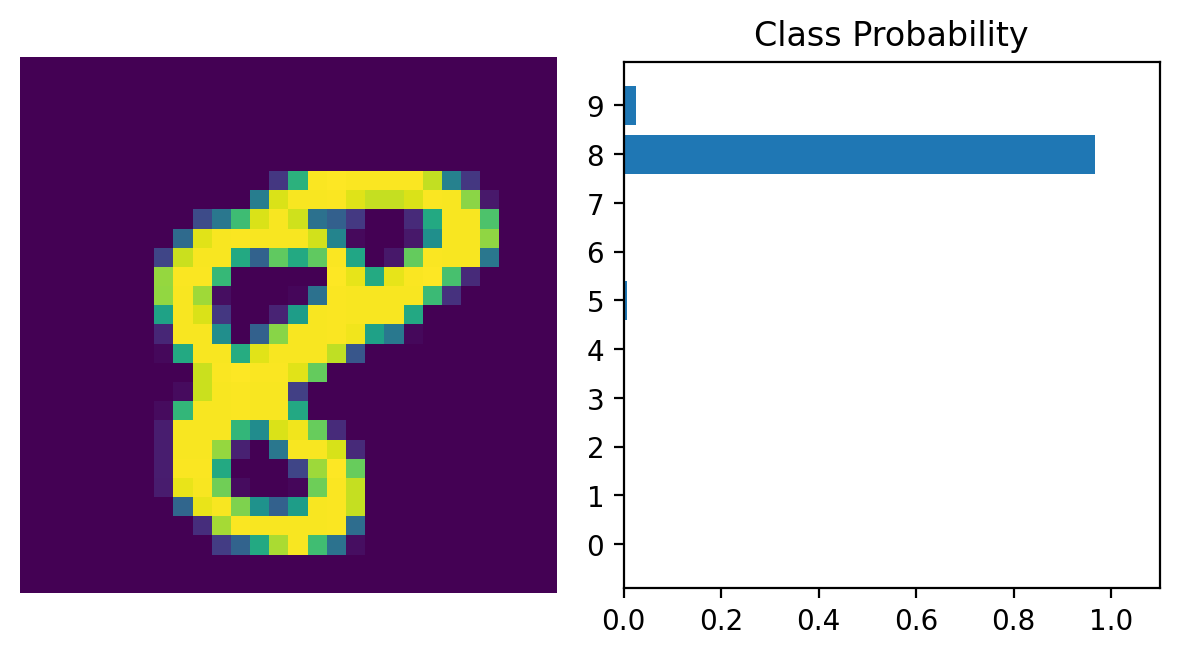

In [12]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
helper.view_classify(img.view(1, 28, 28), ps)